In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')
import spin_models as spin
import Merger_rate_plot as merg

In [2]:
from astropy import constants as const
from astropy import units as u

In [3]:
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

In [4]:
df_binary_GW = pd.read_csv("Data/binary-GW-kick-data.csv",index_col=False)
df_triple_GW = pd.read_csv("Data/triples-GW-kick-data.csv",index_col=False)

In [5]:
df_triple_slingshot = pd.read_csv("Data/triples-slingshot-data.csv",index_col=False)
df_triple_slingshot.head()

,Unnamed: 0,Mass 1,Mass 2,Mass 3,t_merger,Slingshot_kick,Flag
0,0,2.150737e+07,8.204738e+06,5.276829e+07,1.985633e+09,1802.260202,No
1,2,1.546540e+08,4.211761e+07,3.132749e+08,3.025313e+09,301.352009,No
2,3,1.546540e+08,4.211761e+07,3.132749e+08,1.972738e+09,192.293287,No
3,4,9.436961e+06,1.002870e+06,4.551391e+08,4.814316e+09,10529.351190,No
4,7,9.436961e+06,1.002870e+06,4.551391e+08,9.469051e+09,3388.800447,No


In [6]:
zmax = 7
zbinsize = 0.2
lgzbinsize=0.3
lgzmin=-3.0
lgzmax = 1.0

In [7]:
def slignshot_total_rate(Vesc):
        
        t_slinsghot = df_triple_slingshot[df_triple_slingshot['Slingshot_kick']>Vesc]["t_merger"].to_numpy()
        
        if(t_slinsghot.size == 0):
                return 0
        else:
               z_slingshot = z_at_value(cosmo.age,(t_slinsghot/10**9)*u.Gyr,zmin=1e-9)
               merger_rate_sling = merg.total_merger_rate(z_slingshot,zmax,zbinsize,lgzbinsize,lgzmin,lgzmax)
               return merger_rate_sling


In [9]:
def kick_total_rate(Vesc,spin_type):

    #computes the total rate of GW Kicks for a given threshold rate
    #spin-type = aligned/random
    kick_column = 'GW-kick-'+spin_type
    t_triple_GW = df_triple_GW[df_triple_GW[kick_column]>Vesc]["t_merger"].to_numpy()
    
    if(t_triple_GW.size == 0):
        t_binary_GW = df_binary_GW[df_binary_GW[kick_column]>Vesc]["t_merger"].to_numpy()
        if(t_triple_GW.size == 0):
            return 0
        else:
            z_binary_GW = z_at_value(cosmo.age, (t_binary_GW/10**9)*u.Gyr,zmin=1e-9)
            merger_rate_GW = merg.total_merger_rate(z_binary_GW,zmax=7,zbinsize=0.2,lgzbinsize=0.5,lgzmin=-3,lgzmax=1)
            return merger_rate_GW
    else:
        z_triple_GW = z_at_value(cosmo.age, (t_triple_GW/10**9)*u.Gyr,zmin=1e-9)
        t_binary_GW = df_binary_GW[df_binary_GW[kick_column]>Vesc]["t_merger"].to_numpy()
        z_binary_GW = z_at_value(cosmo.age, (t_binary_GW/10**9)*u.Gyr,zmin=1e-9)
        z_GW = np.concatenate((z_binary_GW,z_triple_GW))
        merger_rate_GW = merg.total_merger_rate(z_GW,zmax=7,zbinsize=0.2,lgzbinsize=0.5,lgzmin=-3,lgzmax=1)
        return merger_rate_GW

In [10]:
vesc = np.arange(100,1500,100)

In [11]:
GW_aligned_rates = []
GW_random_rates = []
slingshot_rates = []

In [12]:
for i in range(len(vesc)):
    slingshot_rates.append(slignshot_total_rate(vesc[i]))
    GW_aligned_rates.append(kick_total_rate(vesc[i],'aligned'))
    GW_random_rates.append(kick_total_rate(vesc[i],'random'))

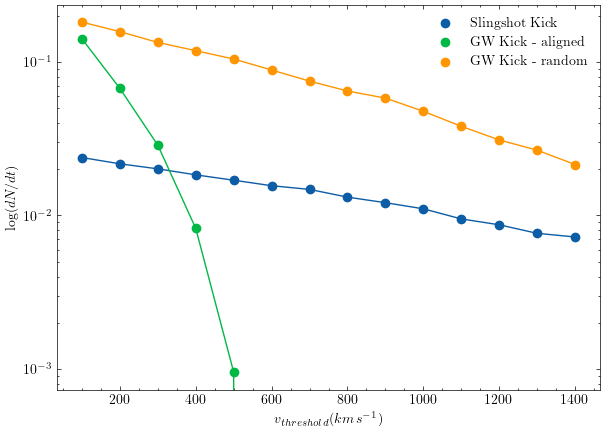

In [16]:
plt.figure(figsize=[7,5])
plt.plot(vesc,slingshot_rates)
plt.scatter(vesc,slingshot_rates,label="Slingshot Kick")
plt.plot(vesc,GW_aligned_rates)
plt.scatter(vesc,GW_aligned_rates,label="GW Kick - aligned")
plt.plot(vesc,GW_random_rates)
plt.scatter(vesc,GW_random_rates,label="GW Kick - random")
plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.xlabel("$v_{threshold} (km \, s^{-1})$")
plt.ylabel("log($d N / d t)$")
plt.show()